In [12]:
using Gen, Plots


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [ ]:
function 

In [43]:
@gen function line_model(xs::Vector{Float64})
#     slope = ({:slope} ~ normal(0, 1))
    intercept = ({:intercept} ~ normal(0, 2))
    angle = ({:angle} ~ uniform(0,2*pi))
    slope = atan(angle)
    
    function y(x)
        return slope * x + intercept
    end
    
    for (i, x) in enumerate(xs)
        ({(:y, i)} ~ normal(y(x), 0.1))
    end
    
    return y
end;

In [57]:
xs = [-5., -4., -3., -2., -1., 0., 1., 2., 3., 4., 5.];
# y = line_model(xs);
trace_in = Gen.simulate(line_model, (xs,));
trace_out = Gen.simulate(line_model, (xs,));

In [58]:
function render_trace(trace; show_data=true)
    xs, = get_args(trace) # ([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0],)
    xmin = minimum(xs)
    xmax = maximum(xs)
    y = get_retval(trace)
    
    # ground truth line
    test_xs = collect(range(-5, stop=5, length=1000))
    fig = plot(test_xs, map(y, test_xs), color="black", alpha=0.5, label=nothing,
                xlim=(xmin, xmax), ylim=(xmin, xmax))

    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        
        # data points
        scatter!(xs, ys, c="black", label=nothing)
    end
    
    return fig
end;

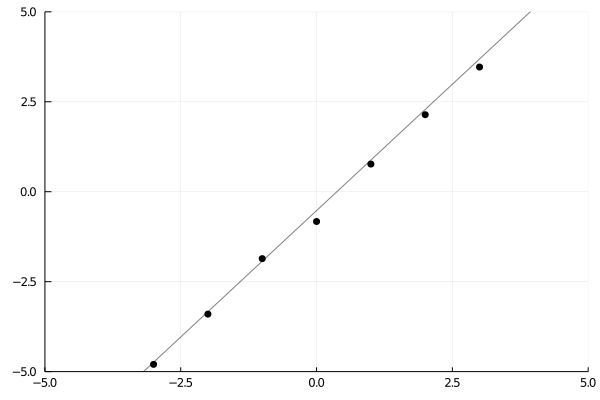

In [59]:
render_trace(trace_in)


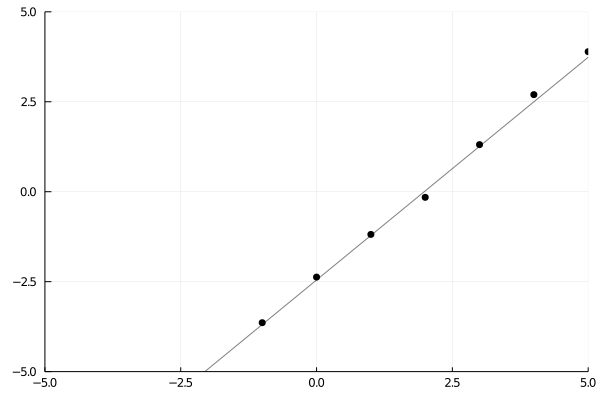

In [60]:
render_trace(trace_out)

In [17]:
function grid(renderer::Function, traces)
    Plots.plot(map(renderer, traces)...)
end;


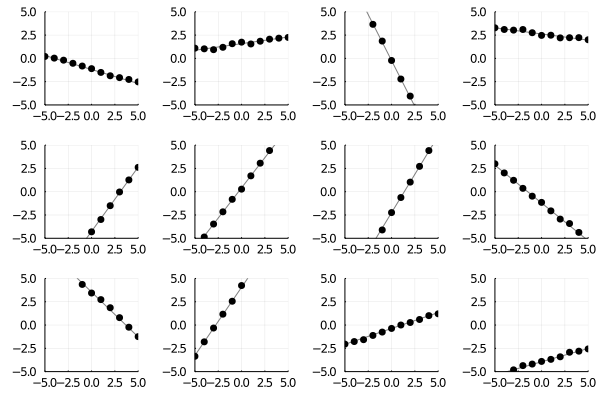

In [26]:
traces = [Gen.simulate(line_model, (xs,)) for _=1:12]
grid(render_trace, traces)

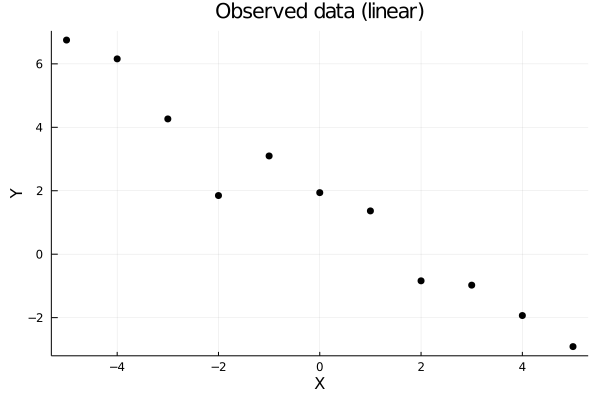

In [27]:
ys = [6.75003, 6.1568, 4.26414, 1.84894, 3.09686, 1.94026, 1.36411, -0.83959, -0.976, -1.93363, -2.91303];
scatter(xs, ys, color="black", label=nothing, title="Observed data (linear)", xlabel="X", ylabel="Y")


In [28]:
function do_inference(model, xs, ys, amount_of_computation)
    
    # Create a choice map that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

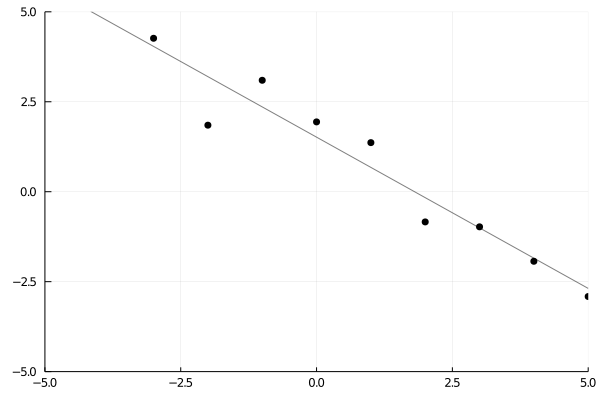

In [29]:
trace = do_inference(line_model, xs, ys, 100)
render_trace(trace)

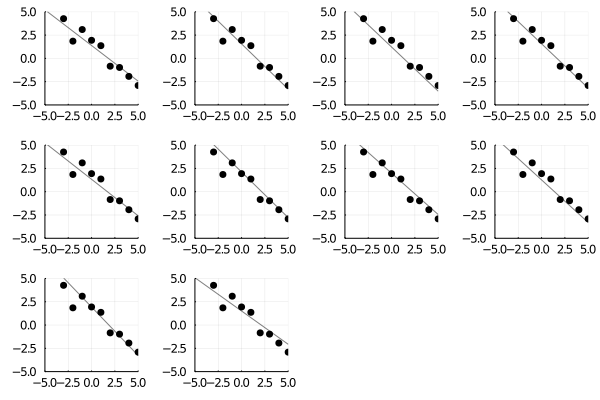

In [30]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
grid(render_trace, traces)

In [31]:
function overlay(renderer, traces; same_data=true, args...)
    fig = renderer(traces[1], show_data=true, args...)
    
    xs, = get_args(traces[1])
    xmin = minimum(xs)
    xmax = maximum(xs)

    for i=2:length(traces)
        y = get_retval(traces[i])
        test_xs = collect(range(-5, stop=5, length=1000))
        fig = plot!(test_xs, map(y, test_xs), color="black", alpha=0.5, label=nothing,
                    xlim=(xmin, xmax), ylim=(xmin, xmax))
    end
    return fig
end;

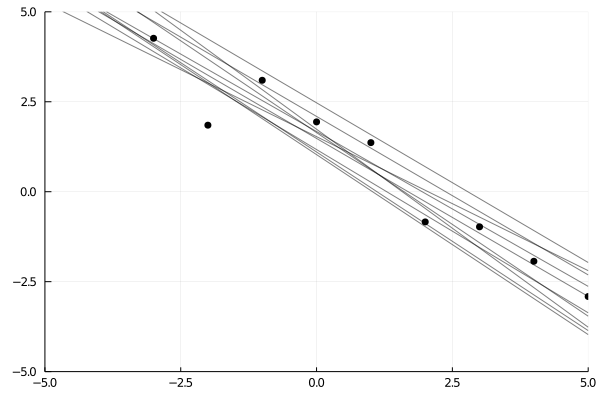

In [32]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
overlay(render_trace, traces)